In [1]:
# Third-party packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Local imports
from utils import get_data
from utils import tech_order, tech_colors
from utils import get_data_sftp
import re
import geopandas as gpd
from shapely.geometry import Point, Polygon

from matplotlib import cm
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D

plt.style.use("style.txt")
pd.options.display.float_format = '{:,.2f}'.format


Bad key legend.labelcolor in file style.txt, line 43 ('legend.labelcolor: black')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution


In [1]:
hostname="shasta-db1.ream.ucsd.edu"
username="n7gonzalez"
scenario_name = ['s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14',
                 's15','s16','s17','s18','s19','s20','s21','s22','s23','s24','s25']
savefig = False
folder_to_save_results="results_v2/"

short_names={'s1':1,'s2':2,'s3':3,'s4':4,'s5':5,'s6':6,'s7':7,'s8':8,'s9':9,'s10':10,'s11':11,'s12':12,'s13':13,
              's14':14,'s15':15,'s16':16,'s17':17,'s18':18,'s19':19,'s20':20,'s21':21,'s22':22,'s23':23,'s24':24,
              's25':25}

In [2]:
fname="dispatch.csv"
dispatch = get_data_sftp(hostname, username, scenario_name, fname)
dispatch.columns= dispatch.columns.str.lower()
dispatch = dispatch.replace({"scenario": short_names})
dispatch

NameError: name 'get_data_sftp' is not defined

In [2]:
wecc = gpd.read_file('/Users/nataliagonzalez/Documents/UCSD PhD/2022/Research 2022/Wave Energy/shape_files/load_areas/wecc_load_areas.shp')
wecc.head()
wecc ['coords'] = wecc ['geometry'].apply(lambda x: x.representative_point().coords[:])
wecc ['coords'] = [coords[0] for coords in wecc['coords']]

In [12]:
print(wecc)

      LOAD_AREA PRIMARY_NE PRIMARY_ST  ECONOMIC_M  RPS_COMPLI  RPS_COM_01  \
0       CA_SMUD         CA         CA        1.08    2,020.00        0.33   
1       CA_SDGE         CA         CA        1.07    2,020.00        0.33   
2        CA_IID    AZNMSNV         CA        1.08    2,020.00        0.33   
3      CA_LADWP         CA         CA        1.07    2,020.00        0.33   
4          NV_S    AZNMSNV         NV        0.98    2,025.00        0.25   
5        CAN_BC   NWPP Can         BC        1.05         NaN         NaN   
6       CAN_ALB   NWPP Can         AB        1.10         NaN         NaN   
7          ID_E       NWPP         ID        0.89         NaN         NaN   
8         MT_NW       NWPP         MT        0.88    2,015.00        0.15   
9         MT_SW       NWPP         MT        0.88    2,015.00        0.15   
10    OR_WA_BPA       NWPP         WA        1.03    2,020.00        0.15   
11    ID_S_OR_E       NWPP         ID        1.02         NaN         NaN   

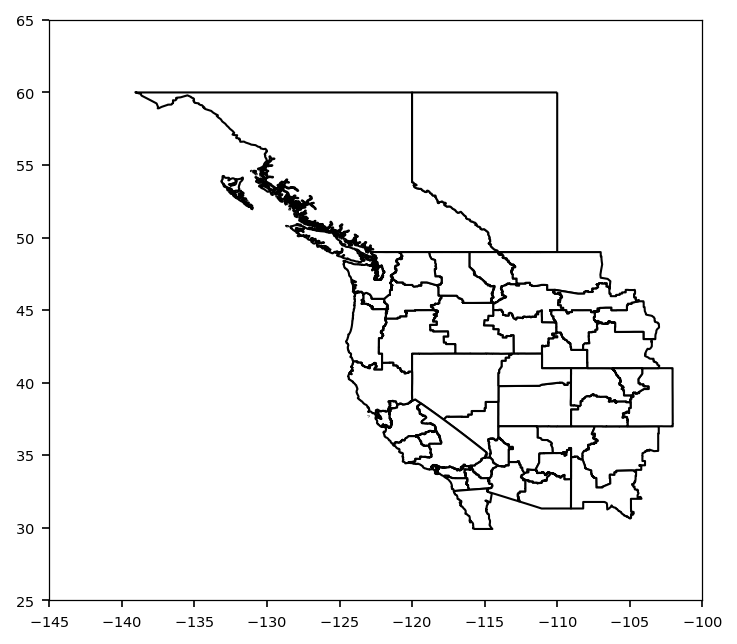

In [16]:
# Plot
fig, ax1 = plt.subplots(1,1,figsize=(5,10), dpi=150)
fig.patch.set_facecolor('white')
fig.tight_layout()
fig.subplots_adjust(wspace=.3)
fig.subplots_adjust(hspace=.2)

ax1.tick_params(labelsize=7)
ax=wecc.plot(ax=ax1, color='white', edgecolor='black', linewidth=1)

#to add load zone labels
# for idx, row in wecc.iterrows():
#    ax1.annotate(text=row['LOAD_AREA'], xy=row['coords'], horizontalalignment='center')

In [ ]:
hours_per_year = 8766

fname="timepoints.csv"
timepoints = get_data(scenario, fname, fpath='inputs')
timepoints.columns= timepoints .columns.str.lower()
timepoints.rename(columns={'timepoint_id': 'timepoint'}, inplace=True)
timepoints = timepoints .replace({"scenario": short_names})

fname="timeseries.csv"
timeseries = get_data(scenario, fname, fpath='inputs')
timeseries.columns= timeseries .columns.str.lower()
timeseries = timeseries .replace({"scenario": short_names})

fname="periods.csv"
periods = get_data(scenario, fname, fpath='inputs')
periods.columns= periods .columns.str.lower()
periods.rename(columns={'investment_period': 'ts_period'}, inplace=True)
periods = periods .replace({"scenario": short_names})

#Merge loads with timepoints
time_info=pd.merge(left=timeseries,right=timepoints, on=['timeseries', 'scenario'])
time_info=pd.merge(left=time_info,right=periods , on=['scenario', 'ts_period'])

time_info['tp_weight']=time_info['ts_duration_of_tp']*time_info['ts_scale_to_period']

period_info=time_info.pivot_table(index=['scenario','ts_period'], values='tp_weight',aggfunc=np.sum )
period_info.reset_index(inplace=True)
period_info.rename(columns={'tp_weight': 'hours_in_period'}, inplace=True)
period_info = pd.merge(left=period_info, right = periods, on=['scenario', 'ts_period'])
period_info['err_plain'] = (period_info['period_end'] - period_info['period_start'])*hours_per_year - period_info['hours_in_period']
period_info['err_add_one'] =  (period_info['period_end'] + 1 - period_info['period_start'])*hours_per_year - period_info['hours_in_period']
period_info.loc[:, 'add_one_to_period_end_rule']= period_info.apply(lambda x: 1 if np.absolute(x['err_add_one'])<np.absolute(x['err_plain']) else 0, axis=1)
period_info['period_length_years'] = period_info['period_end'] - period_info['period_start'] + period_info['add_one_to_period_end_rule']